# Assignment 6 - Hop Skip Jump

## Imports

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math

# Enable inline plotting
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [8]:
np.random.seed(314)

## Training MNIST classifier

In [15]:
def build_mnist_model():
    
    activation = 'relu'
    # input image dimensions
    img_rows, img_cols, img_colors = 28, 28, 1
    
    model = keras.Sequential()
    model.add(layers.Conv2D(8, kernel_size=(3, 3), input_shape=(img_rows, img_cols, img_colors), activation=activation))
    model.add(layers.Conv2D(8, (3, 3), activation=activation))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation=activation))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes))
    model.add(layers.Activation('softmax', name='y_pred'))
              
    return model

def train_model(num_classes, train_images, train_labels, test_images, test_labels):
    # Train the model
    batch_size = 128
    maxepoches = 12
    learning_rate = 0.1
    lr_decay = 1e-6
    lr_drop = 20

    def lr_scheduler(epoch):
        return learning_rate * (0.5 ** (epoch // lr_drop))
    reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)

    model = build_mnist_model()

    model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=[keras.metrics.CategoricalAccuracy()])

    history = model.fit(train_images, train_labels,
                        batch_size=batch_size,
                        epochs=maxepoches,
                        verbose=1,
                        validation_data=(test_images, test_labels),
                        callbacks=[reduce_lr])

    return model


def normalize(x_train,x_test):
    x_train -= x_train.min()
    x_train /= x_train.max()
    x_test -= x_test.min()
    x_test /= x_test.max()
    
    return x_train, x_test

In [5]:
num_classes = 10

img_rows, img_cols, img_colors = 28, 28, 1
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1)
test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)
train_images, test_images = normalize(train_images, test_images)
    
train_labels = keras.utils.to_categorical(train_labels, num_classes)
test_labels = keras.utils.to_categorical(test_labels, num_classes)

In [16]:
model = train_model(num_classes, train_images, train_labels, test_images, test_labels)

Epoch 1/12
469/469 [==============================] - 16s 34ms/step - loss: 0.9963 - categorical_accuracy: 0.6762 - val_loss: 0.2969 - val_categorical_accuracy: 0.9175
Epoch 2/12
469/469 [==============================] - 16s 34ms/step - loss: 0.4323 - categorical_accuracy: 0.8673 - val_loss: 0.2147 - val_categorical_accuracy: 0.9398
Epoch 3/12
469/469 [==============================] - 17s 36ms/step - loss: 0.3493 - categorical_accuracy: 0.8951 - val_loss: 0.1807 - val_categorical_accuracy: 0.9485
Epoch 4/12
469/469 [==============================] - 17s 36ms/step - loss: 0.3038 - categorical_accuracy: 0.9082 - val_loss: 0.1582 - val_categorical_accuracy: 0.9519
Epoch 5/12
469/469 [==============================] - 17s 37ms/step - loss: 0.2715 - categorical_accuracy: 0.9193 - val_loss: 0.1422 - val_categorical_accuracy: 0.9558
Epoch 6/12
469/469 [==============================] - 17s 37ms/step - loss: 0.2480 - categorical_accuracy: 0.9243 - val_loss: 0.1281 - val_categorical_accuracy:

## Interpolating images

### Choosing 2 images with different labels

Text(0.5, 1.0, 'destination image, label=9')

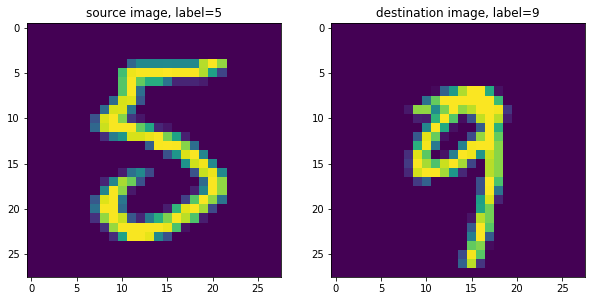

In [35]:
source_idx = np.random.randint(len(train_labels))
source_img, source_label = train_images[source_idx], train_labels[source_idx]
same_label = True
while same_label:
    dest_idx = np.random.randint(len(train_labels))
    dest_img, dest_label = train_images[dest_idx], train_labels[dest_idx]
    if np.argmax(dest_label) != np.argmax(source_label):
        same_label = False
        
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.imshow(source_img.squeeze())
ax1.set_title(f'source image, label={np.argmax(source_label)}')
ax2.imshow(dest_img.squeeze())
ax2.set_title(f'destination image, label={np.argmax(dest_label)}')

### Interpolating

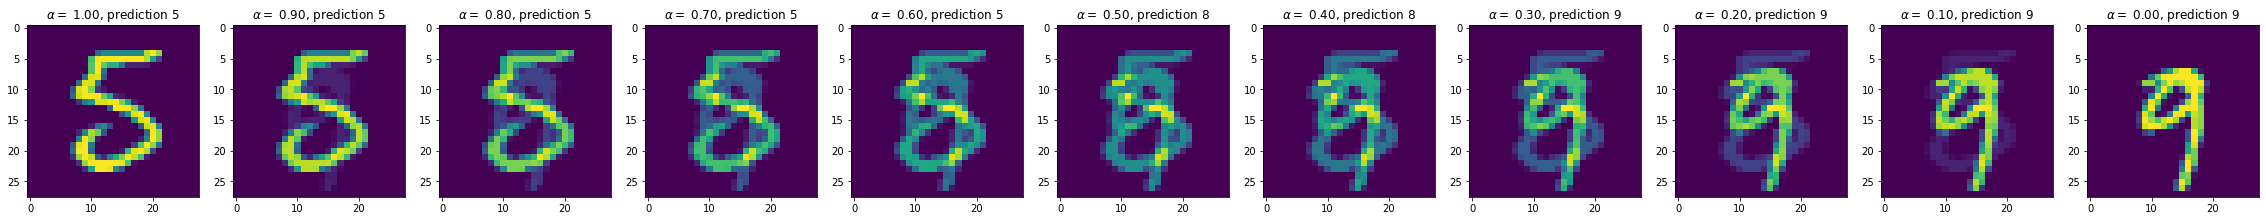

In [46]:
num_interpolation = 11
interpolating_coefs = np.linspace(0, 1, num_interpolation)
fig, axis = plt.subplots(1, num_interpolation, figsize=(40,40))
for idx, coef in enumerate(interpolating_coefs):
    input_image = coef * dest_img + (1-coef) * source_img
    pred = np.argmax(model(np.expand_dims(input_image, axis=0)))
    axis[idx].imshow(input_image.squeeze())
    axis[idx].set_title(f'$\\alpha = $ {1-coef:1.2f}, prediction {pred}')

## Binary search

In [65]:
def binary_search(src_img, dest_img, dest_label, model, eps=1e-7):
    
    min_alpha = 0
    max_alpha = 1
    
    while max_alpha - min_alpha > eps:
        middle = 0.5 * (min_alpha + max_alpha)
        interpolated_image = (1-middle) * src_img + middle * dest_img

        if np.argmax(model(np.expand_dims(interpolated_image, axis=0))) != np.argmax(dest_label):
            min_alpha = middle
        else:
            max_alpha = middle
    
    return max_alpha

In [66]:
boundary_coefficient = binary_search(source_img, dest_img, dest_label, model)

In [67]:
boundary_coefficient

0.6148448586463928

Text(0.5, 1.0, 'boundary image, prediction = 9')

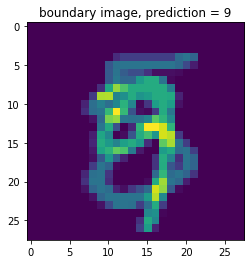

In [70]:
boundary_img = (boundary_coefficient+eps) * dest_img + (1-boundary_coefficient - eps) * source_img
pred = np.argmax(model(np.expand_dims(boundary_img, axis=0)))
plt.imshow(boundary_img.squeeze())
plt.title(f'boundary image, prediction = {pred}')

## Derivating S

In [71]:
@tf.function
def deriv_S(f, x_input, target):
    with tf.GradientTape() as grad:
        input_tensor = x_input
        softmax = f(input_tensor)
    soft_grads = grad.gradient(softmax, input_tensor)
    target_grad = soft_grads[target]
    max_grad = soft_grads[np.argmax(softmax)]
    return target_grad - max_grad